In [1]:
import os
import numpy as np
import pandas as pd

from dask_searchcv import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import f1_score, precision_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Set constants
alphas= [0.000001, 0.00001, 0.0001, 0.001, 0.001, 0.01]
l1_mixing = [0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2]

In [4]:
file = os.path.join('data', 'compass_x_train.tsv.gz')
x_df = pd.read_table(file, index_col=0).T
print(x_df.shape)
x_df.head(2)

(706, 8000)


GENE_ID,ENSG00000000419,ENSG00000001036,ENSG00000001167,ENSG00000001461,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000273015,ENSG00000273018,ENSG00000273047,ENSG00000273061,ENSG00000273148,ENSG00000273173,ENSG00000273271,ENSG00000273338,ENSG00000273344,ENSG00000273472
MMRF_1021_1_BM,0.002039,0.001428,0.000656,0.001638,0.001126,0.000682,0.002040,0.000836,0.001092,0.003595,...,0.000773,0.000953,0.001499,0.000390,0.000284,0.007063,0.000252,0.005463,0.000286,0.000517
MMRF_1024_2_BM,0.001164,0.000949,0.000828,0.000658,0.000866,0.000776,0.001559,0.000898,0.001600,0.001572,...,0.001248,0.006047,0.000600,0.000672,0.000420,0.004150,0.000222,0.001641,0.000427,0.000931


In [5]:
file = os.path.join('data', 'compass_y_train.tsv')
y_df = pd.read_table(file, index_col=0)
print(y_df.shape)
y_df.head(2)

(706, 1)


,ras_status
MMRF_1021_1_BM,1
MMRF_1024_2_BM,0


In [26]:
weighted_f1 = make_scorer(f1_score, average='weighted')

In [27]:
clf_parameters = {'classify__loss': ['hinge'],
                  'classify__penalty': ['elasticnet'],
                  'classify__alpha': alphas,
                  'classify__l1_ratio': l1_mixing,
                  'classify__max_iter': [200]}

In [28]:
estimator = Pipeline(
    steps=[('classify',
            SGDClassifier(random_state=0,
                          class_weight='balanced'))]
)

cv_pipeline = GridSearchCV(estimator=estimator,
                           param_grid=clf_parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring=weighted_f1)

In [31]:
%%time
cv_pipeline.fit(X=x_df, y=y_df.ras_status)

CPU times: user 1h 5min 51s, sys: 4.21 s, total: 1h 5min 55s
Wall time: 17min 48s


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__penalty': ['elasticnet'], 'classify__l1_ratio': [0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2], 'classify__loss': ['hinge'], 'classify__max_iter': [200], 'classify__alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.001, 0.01]},
       refit=True, return_train_score='warn', scheduler=None,
       scoring=make_scorer(f1_score, average=weighted))

In [32]:
cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training sc

In [33]:
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__max_iter,param_classify__penalty,rank_test_score,...,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__max_iter,classify__penalty
0,26.640288,0.003663,0.566956,0.804232,1e-06,0.08,hinge,200,elasticnet,28,...,0.897889,0.235869,0.000096,0.074414,0.140648,0.000001,0.08,hinge,200,elasticnet
1,26.307183,0.003661,0.589456,0.841416,1e-06,0.09,hinge,200,elasticnet,20,...,0.775302,0.088912,0.000100,0.050241,0.089578,0.000001,0.09,hinge,200,elasticnet
2,26.398609,0.003832,0.563369,0.815930,1e-06,0.1,hinge,200,elasticnet,31,...,0.874502,0.130014,0.000263,0.106775,0.173646,0.000001,0.10,hinge,200,elasticnet
3,26.223121,0.003662,0.568381,0.852778,1e-06,0.11,hinge,200,elasticnet,27,...,0.911256,0.313489,0.000111,0.090714,0.108119,0.000001,0.11,hinge,200,elasticnet
4,26.369358,0.003612,0.562074,0.805754,1e-06,0.12,hinge,200,elasticnet,33,...,0.715676,0.259825,0.000024,0.062464,0.117355,0.000001,0.12,hinge,200,elasticnet
5,26.353508,0.003601,0.541412,0.821496,1e-06,0.15,hinge,200,elasticnet,34,...,0.910091,0.188270,0.000009,0.105287,0.175589,0.000001,0.15,hinge,200,elasticnet
6,26.367157,0.003715,0.577485,0.844082,1e-06,0.2,hinge,200,elasticnet,25,...,0.825930,0.309501,0.000207,0.051348,0.090595,0.000001,0.20,hinge,200,elasticnet
7,27.671127,0.003647,0.578217,0.823611,1e-05,0.08,hinge,200,elasticnet,24,...,0.833562,0.417830,0.000035,0.052834,0.076696,0.000010,0.08,hinge,200,elasticnet
8,27.651309,0.003629,0.562790,0.820094,1e-05,0.09,hinge,200,elasticnet,32,...,0.818688,0.313662,0.000016,0.092329,0.108422,0.000010,0.09,hinge,200,elasticnet
9,27.574765,0.003638,0.536406,0.791108,1e-05,0.1,hinge,200,elasticnet,35,...,0.855491,0.284993,0.000035,0.059097,0.090887,0.000010,0.10,hinge,200,elasticnet


In [34]:
a = pd.DataFrame(cv_pipeline.best_estimator_.named_steps['classify'].coef_).T
a.columns = ['wildtype', 'KRAS', 'NRAS']
a.index = x_df.columns
a.head()

,wildtype,KRAS,NRAS
GENE_ID,,,
ENSG00000000419,0.0,0.0,0.0
ENSG00000001036,0.0,0.0,0.0
ENSG00000001167,0.0,0.0,0.0
ENSG00000001461,0.0,0.0,0.0
ENSG00000001561,0.0,0.0,0.0


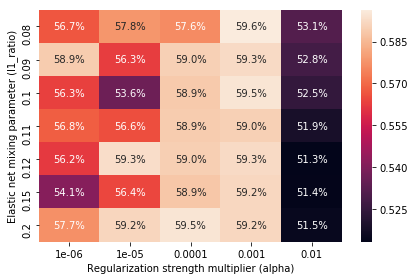

In [35]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()

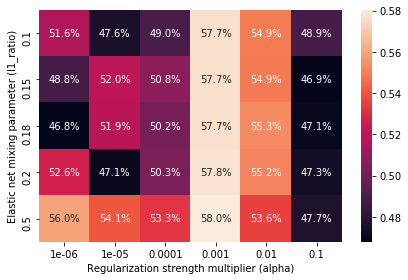

In [199]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()

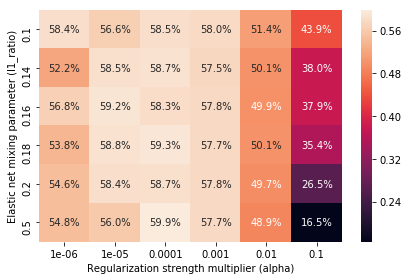

In [218]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()

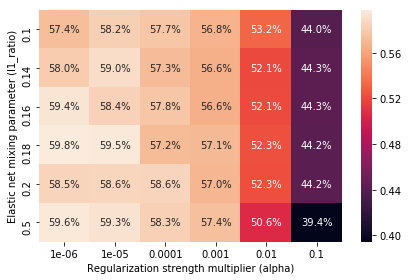

In [227]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()